In [3]:
%pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import random
import matplotlib

In [6]:
try:

    # Create a new model
    m = gp.Model("mip1")

    # Create variables
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "c1")

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x98886187
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3


In [7]:
nodes = []
edges = []

node_file = open('nodes.txt', 'r')
node_lines = node_file.readlines()
for node_line in node_lines:
  nodes.append(node_line.replace('\n', ''))

node_file.close()

edge_file = open('topology.txt', 'r')
edge_lines = edge_file.readlines()[1:]
for edge_line in edge_lines:
  edge = edge_line.split()
  if not (edge[0:3] in edges or [edge[1], edge[0], edge[2]] in edges):
    edges.append(edge[0:3])

edge_file.close()
  
print(edges)
print(nodes)


[['9', '10', '1000000000'], ['9', '8', '1000000000'], ['9', '4', '1000000000'], ['8', '3', '1000000000'], ['8', '7', '1000000000'], ['8', '4', '1000000000'], ['3', '4', '1000000000'], ['2', '0', '1000000000'], ['1', '10', '1000000000'], ['1', '6', '1000000000'], ['0', '7', '1000000000'], ['0', '4', '1000000000'], ['7', '10', '1000000000'], ['7', '6', '1000000000'], ['6', '10', '1000000000'], ['6', '5', '1000000000'], ['5', '4', '1000000000'], ['4', '10', '1000000000']]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


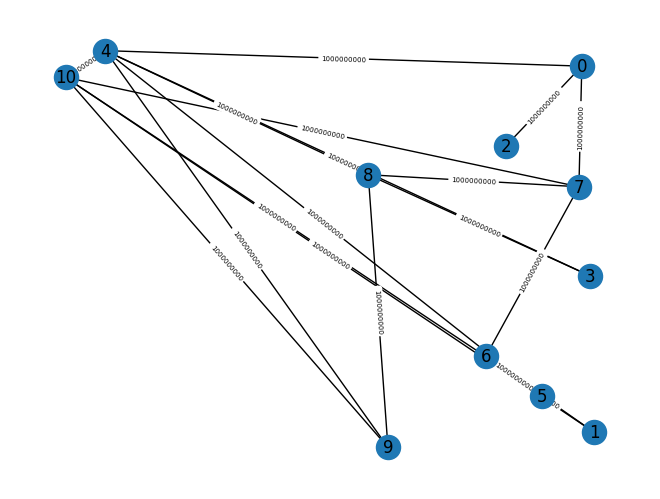

In [14]:
G = nx.Graph()
G.add_nodes_from(nodes)
for i in range(len(nodes)):
  G.nodes[str(i)]['pos'] = (random.uniform(0, 5), random.uniform(0,5))
for edge in edges:
  G.add_edge(edge[0], edge[1], bandwidth = edge[2])

pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos, with_labels=True)
labels = nx.get_edge_attributes(G,'bandwidth')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=5)
matplotlib.pyplot.savefig('/Users/andriiiermolaiev/Code/sdn_te/topology')



In [9]:
#formatted as a list of lists of lists, where each entry corresponds to a
#timestamp, increasing as time progresses. Each list within is a list 
#of lists where each corresponds to demands for that node pair at 
#that time, e.g. demands[0][3][7] is the demand initially from node 4
#to node 8
demands = []
demand_file = open('demand.txt', 'r')
demand_lines = demand_file.readlines()
for demand_line in demand_lines:
  demand = demand_line.split()
  t_demand = [demand[i:i + 11] for i in range(0, len(demand), 11)]
  demands.append(t_demand)

  